In [9]:
import numpy as np;
import pandas as pd;
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
mccScorer = make_scorer(matthews_corrcoef)
from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [11]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [12]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [5]:
def GDBoost_HP_tuning(X,Y):
  # define models
  model = GradientBoostingClassifier()

  pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_classif,X.shape[1]//2)),
     ('model',model)
    ]
  )
  #"selector__k":[int(x) for x in np.linspace(start = 5 , stop = X.shape[1]//2, num = 50)],
  # define parameters
  n_estimators = [10, 100, 1000]
  learning_rate = [0.01, 0.1]
  subsample = [0.5, 0.7, 1.0]
  #max_depth = [3, 7, 9]
  
  param_dist = {
                "selector__k":[int(x) for x in np.linspace(start = 5 , stop = X.shape[1]//10, num = 10)],
                "model__n_estimators": n_estimators,
                "model__subsample": subsample,
                "model__learning_rate": learning_rate,
              }


  # Instantiate the GridSearchCV object
  search = GridSearchCV(pipeline, param_grid=param_dist,scoring=mccScorer, cv=2)

  # Fit it to the data
  result = search.fit(X,Y.astype('int'))

  # Print the tuned parameters and score
  print("Best MCC score is {}".format(result.best_score_))
  print("Tuned Parameters: {}".format(result.best_params_))

In [13]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [14]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [15]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [16]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [17]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [21]:
def GDBoost_with_cross_validation(X,Y,n_estimator,learning_rate,sub_sample,endpointLabel,numberOfFeatures=1):
  
  model = GradientBoostingClassifier(n_estimators=n_estimator,learning_rate=learning_rate,subsample=sub_sample,random_state=1)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1'}
  
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-GDBoost-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-GDBoost-'+endpointLabel)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.271 SD: (0.161)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [1.85437966e+01 7.66735077e-03 2.71117764e-01 7.46153846e-01
 5.02380952e-01 3.66666667e-01 4.18441558e-01]
SD [3.60247796e-01 1.12636911e-04 1.61055991e-01 5.75639598e-02
 1.51889087e-01 1.23809524e-01 1.34490286e-01]


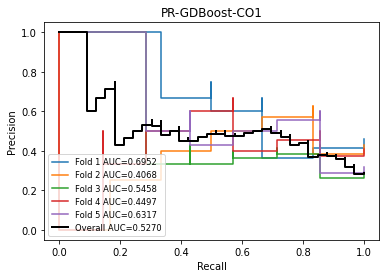

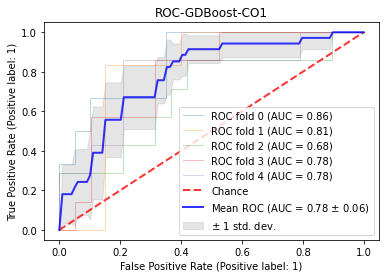

In [22]:
GDBoost_with_cross_validation(co1['X'],co1['Y'],500,0.1,0.9,'CO1',best_co1)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.492 SD: (0.165)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [1.28547210e+01 8.40802193e-03 4.92002756e-01 7.46153846e-01
 7.00000000e-01 6.81818182e-01 6.66681750e-01]
SD [0.53566246 0.00152058 0.16491607 0.06705998 0.08964531 0.23467931
 0.12810253]


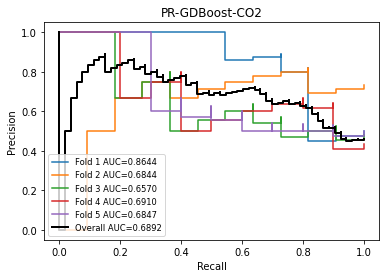

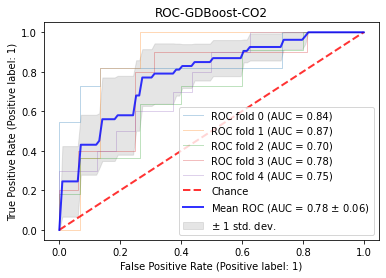

In [23]:
GDBoost_with_cross_validation(co2['X'],co2['Y'],500,0.1,0.9,'CO2',best_co2)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.293 SD: (0.085)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [3.12843306e+02 8.27587128e-02 2.93473624e-01 7.79411765e-01
 7.33333333e-01 2.15441176e-01 3.16083945e-01]
SD [2.0314624  0.06645056 0.0846126  0.02460765 0.22607767 0.07717436
 0.08127864]


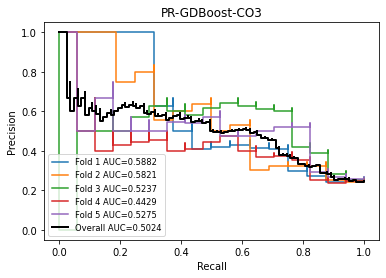

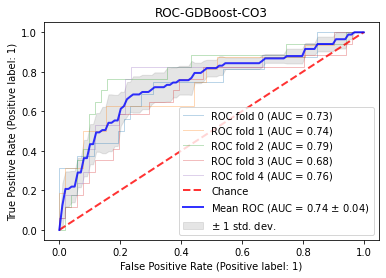

In [24]:
GDBoost_with_cross_validation(co3['X'],co3['Y'],500,0.1,0.9,'CO3',best_co3)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.224 SD: (0.110)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [2.20696957e+02 3.87703896e-02 2.24221977e-01 8.52941176e-01
 5.16666667e-01 1.58181818e-01 2.37728938e-01]
SD [0.70335037 0.00161088 0.10978334 0.01610949 0.13333333 0.08143344
 0.10756016]


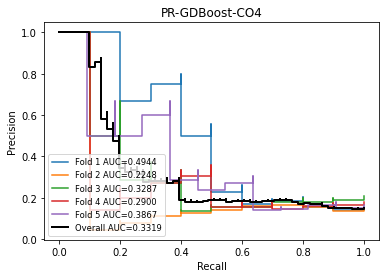

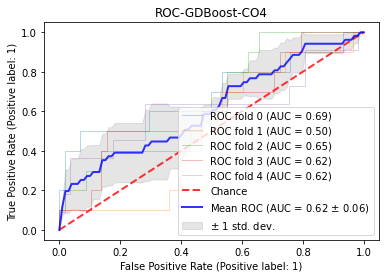

In [25]:
GDBoost_with_cross_validation(co4['X'],co4['Y'],500,0.1,0.9,'CO4',best_co4)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.861 SD: (0.072)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [8.29903434e+01 2.65213966e-02 8.60863132e-01 9.29411765e-01
 8.88899431e-01 9.59080460e-01 9.22029496e-01]
SD [2.82468522 0.0029818  0.07154725 0.03649904 0.05886342 0.02532495
 0.04008129]


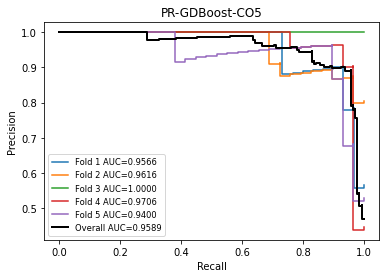

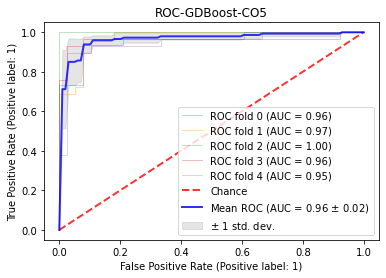

In [26]:
GDBoost_with_cross_validation(co5['X'],co5['Y'],500,0.1,0.9,'CO5',best_co5)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': 1, 'subsample': 0.9, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.328 SD: (0.048)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [1.17211774e+02 3.25981140e-02 3.27792906e-01 6.82352941e-01
 6.95185269e-01 8.20000000e-01 7.52039914e-01]
SD [3.46577731e+00 3.76625192e-04 4.80464441e-02 2.20097493e-02
 1.65786897e-02 3.67423461e-02 1.95076862e-02]


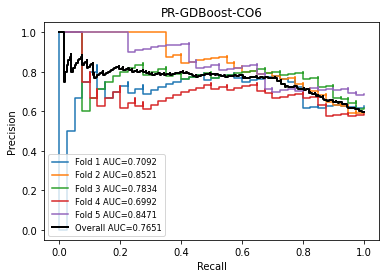

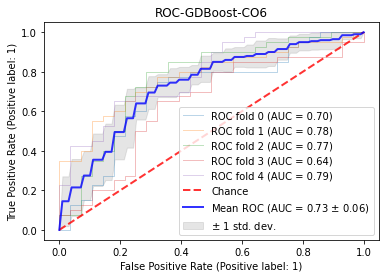

In [27]:
GDBoost_with_cross_validation(co6['X'],co6['Y'],500,0.1,0.9,'CO6',best_co6)

In [ ]:
GDBoost_HP_tuning(**co1);

In [ ]:
GDBoost_HP_tuning(**co2);

In [ ]:
GDBoost_HP_tuning(**co3);